In [1]:

import sys
import os
base_dir = os.path.abspath("../")
sys.path.append(base_dir)

import multiprocessing as mp
import time

from PIL import Image

import cv2
import numpy as np
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
import glob
import kornia

from progressbar import ProgressBar
from tqdm.notebook import tqdm

from imageloaders.DREAM import ImageDataLoaderSyntheticCopp

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from utils import *
from torch.utils.tensorboard import SummaryWriter
import transforms3d.quaternions as quaternions
import transforms3d.euler as euler


In [2]:
import argparse
parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.n_kp = 6
args.scale = 0.5
args.height = 720
args.width = 1280
args.fx = -914.024
args.fy = -914.024
args.px = 640.
args.py = 360.
args.lim=[-1., 1., -1., 1.]
args.data_folder = '/home/deep/ur3e_gesture_estimate/result/img/'   ### data in folder "sos"
args.csv_data = '/home/deep/ur3e_gesture_estimate/result/data/record.csv'
args.test_data_folder = '/home/deep/ur3e_gesture_estimate/test/img/'
args.csv_test = '/home/deep/ur3e_gesture_estimate/result/data/record_test.csv'
# args.data_folder = args.test_data_folder
# args.csv_data = args.csv_test
args.use_gpu = True
args.batch_size = 4
args.num_workers = 8
args.lr = 1e-5
args.beta1 = 0.9
args.n_epoch = 1000
args.out_dir = '/home/deep/CtRNet-robot-pose-estimation/outputs'
args.ckp_per_epoch = 10


args.height = int(args.height * args.scale)
args.width = int(args.width * args.scale)
args.fx = args.fx * args.scale
args.fy = args.fy * args.scale
args.px = args.px * args.scale
args.py = args.py * args.scale

if not os.path.exists(args.out_dir):
    os.mkdir(args.out_dir)

In [3]:
trans_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


datasets = {}
dataloaders = {}
data_n_batches = {}
for phase in ['train','valid']:
    datasets[phase] = ImageDataLoaderSyntheticCopp(img_folder = args.data_folder if phase=='train' else args.test_data_folder, csv_path=args.csv_data if phase=='train' else args.csv_test, scale = args.scale, trans_to_tensor = trans_to_tensor)


    dataloaders[phase] = DataLoader(
        datasets[phase], batch_size=args.batch_size,
        shuffle=True if phase == 'train' else False,
        num_workers=args.num_workers)

    data_n_batches[phase] = len(dataloaders[phase])

print(data_n_batches)



{'train': 2750, 'valid': 250}


In [4]:
import models.BPnP as BPnP
import kornia as kn

from models.keypoint_seg_resnet import KeyPointSegNet

keypoint_seg_predictor = KeyPointSegNet(args, use_gpu=args.use_gpu)
if args.use_gpu:
    keypoint_seg_predictor = keypoint_seg_predictor.cuda()

#keypoint_seg_predictor = torch.nn.DataParallel(keypoint_seg_predictor, device_ids=[0])
bpnp = BPnP.BPnP.apply


In [5]:
criterionMSE_sum = torch.nn.MSELoss(reduction='sum')
criterionMSE_mean = torch.nn.MSELoss(reduction='mean')
criterionBCE = torch.nn.BCEWithLogitsLoss()

optimizer = optim.Adam(keypoint_seg_predictor.parameters(), lr=args.lr, betas=(args.beta1, 0.999))
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, verbose=True)


In [6]:


if args.use_gpu:
    keypoint_seg_predictor = keypoint_seg_predictor.cuda()
    criterionMSE_sum = criterionMSE_sum.cuda()
    criterionMSE_mean = criterionMSE_mean.cuda()
    criterionBCE = criterionBCE.cuda()

if args.use_gpu:
    device = "cuda"
else:
    device = "cpu"
    

fx = args.fx
fy = args.fy
px = args.px
py = args.py
intrinsics = np.array([[  fx        ,    0.   ,  px        ],
                       [  0.        ,    fy   ,  py        ],
                       [  0.        ,    0.   ,   1.      ]])

K = torch.tensor(intrinsics, device=device, dtype=torch.double)

In [7]:
from models.robot_arm import URArm
from models.mesh_renderer import RobotMeshRenderer
from pytorch3d.structures import Meshes

urdf_file = os.path.join("/home/deep/CtRNet-robot-pose-estimation/urdfs/ur_description/urdf/ur3e.urdf")
ur_arm = URArm(urdf_file=urdf_file)


focal_length = [-fx,-fy]
principal_point = [px, py]
image_size = [args.height,args.width]
mesh_files = ["/home/deep/CtRNet-robot-pose-estimation/urdfs/ur_description/meshes/ur3e/base/base.obj",
              "/home/deep/CtRNet-robot-pose-estimation/urdfs/ur_description/meshes/ur3e/shoulder/shoulder.obj",
              "/home/deep/CtRNet-robot-pose-estimation/urdfs/ur_description/meshes/ur3e/upperarm/upperarm.obj",
              "/home/deep/CtRNet-robot-pose-estimation/urdfs/ur_description/meshes/ur3e/forearm/forearm.obj",
              "/home/deep/CtRNet-robot-pose-estimation/urdfs/ur_description/meshes/ur3e/wrist1/wrist1.obj",
              "/home/deep/CtRNet-robot-pose-estimation/urdfs/ur_description/meshes/ur3e/wrist2/wrist2.obj",
              "/home/deep/CtRNet-robot-pose-estimation/urdfs/ur_description/meshes/ur3e/wrist3/wrist3.obj",
             ]
# mesh_files = ["/home/deep/CtRNet-robot-pose-estimation/urdfs/ur_description/meshes/ur3e/base/base.obj",
#               "/home/deep/CtRNet-robot-pose-estimation/urdfs/ur_description/meshes/ur3e/shoulder/shoulder.obj",
#               "/home/deep/CtRNet-robot-pose-estimation/urdfs/ur_description/meshes/ur3e/upperarm/upperarm.obj",
#               "/home/deep/CtRNet-robot-pose-estimation/urdfs/ur_description/meshes/ur3e/forearm/forearm.obj",
#               "/home/deep/CtRNet-robot-pose-estimation/urdfs/ur_description/meshes/ur3e/wrist1/wrist1.obj",
#               "/home/deep/CtRNet-robot-pose-estimation/urdfs/ur_description/meshes/ur3e/wrist2/wrist2.obj",
#               "/home/deep/CtRNet-robot-pose-estimation/urdfs/ur_description/meshes/ur3e/wrist3/wrist3.obj",
#              ]

panda_renderer = RobotMeshRenderer(
    focal_length=focal_length, principal_point=principal_point, image_size=image_size, 
    robot=ur_arm, mesh_files=mesh_files, device=device)


ERobot: ur3e_robot (by UR), 6 joints (RRRRRR), 2 branches, dynamics, geometry, collision
┌─────┬───────────────────┬───────┬───────────────────┬────────────────────────────────────────────────────────────────────┐
│link │       link        │ joint │      parent       │                        ETS: parent to link                         │
├─────┼───────────────────┼───────┼───────────────────┼────────────────────────────────────────────────────────────────────┤
│   0 │ base_link         │       │ BASE              │                                                                    │
│   1 │ base_link_inertia │       │ base_link         │ SE3(0°, -0°, 180°)                                                 │
│   2 │ shoulder_link     │     0 │ base_link_inertia │ SE3(0, 0, 0.1519) ⊕ Rz(q0)                                         │
│   3 │ upper_arm_link    │     1 │ shoulder_link     │ SE3(90°, -0°, 0°) ⊕ Rz(q1)                                         │
│   4 │ forearm_link      │     2 │ 

2024-07-18 00:14:24.170088: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


  0%|          | 0/2750 [00:00<?, ?it/s]

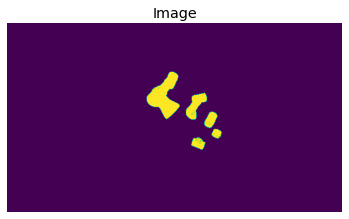

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


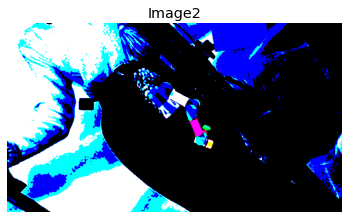

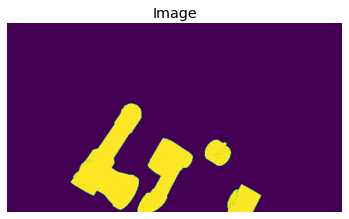

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


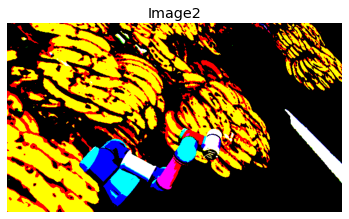

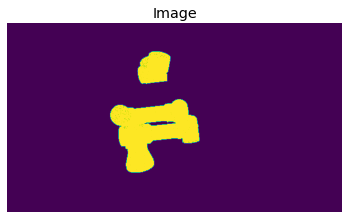

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


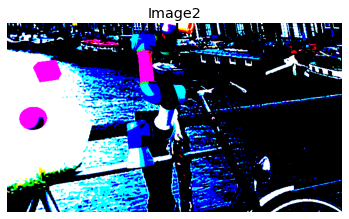

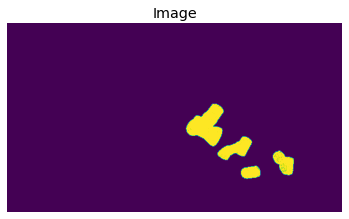

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


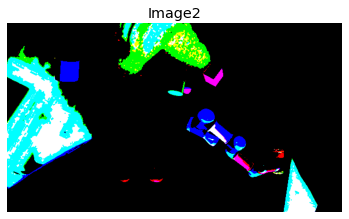

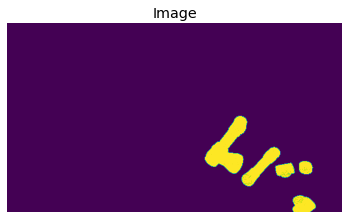

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


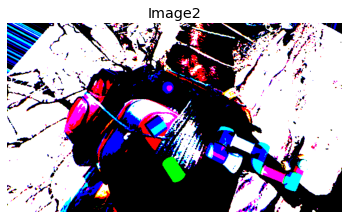

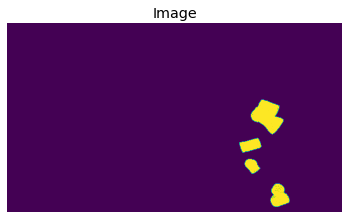

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


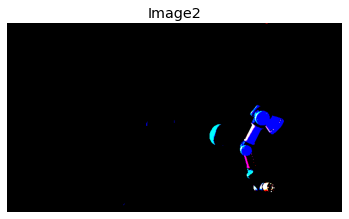

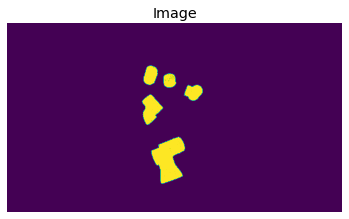

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


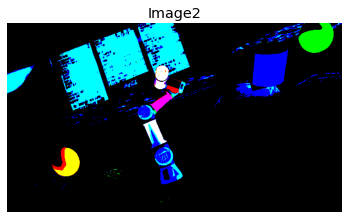

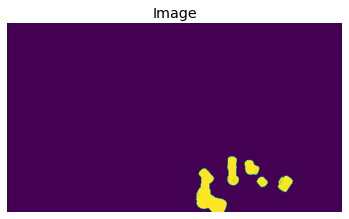

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


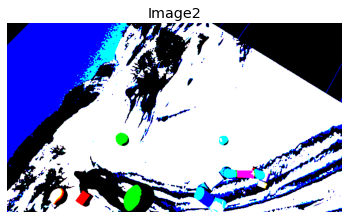

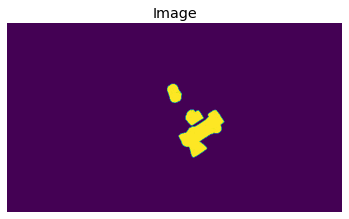

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


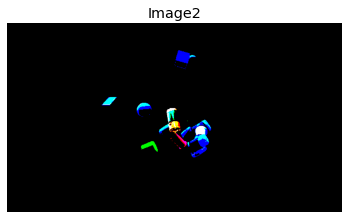

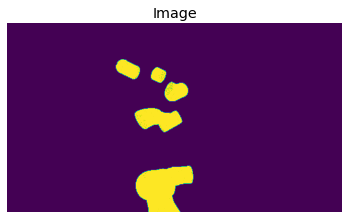

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


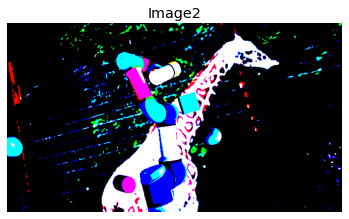

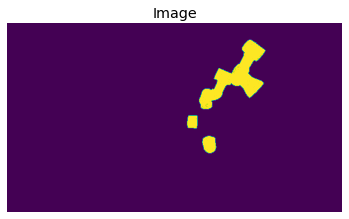

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


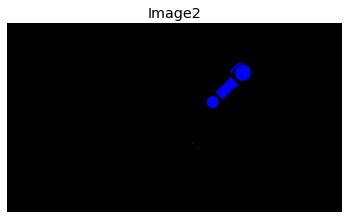

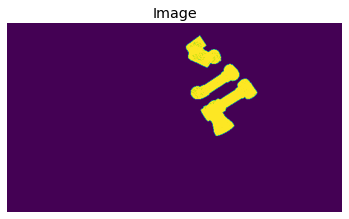

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


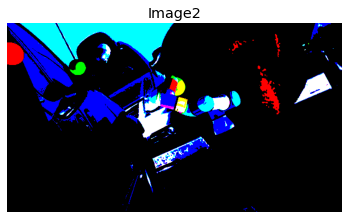

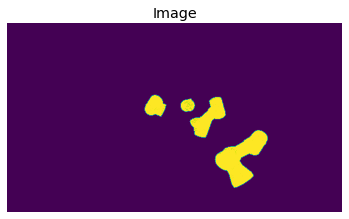

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


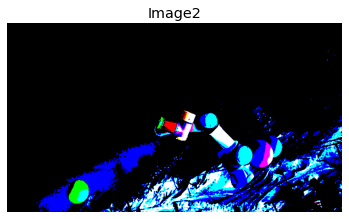

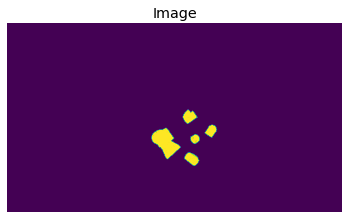

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


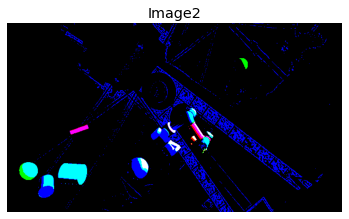

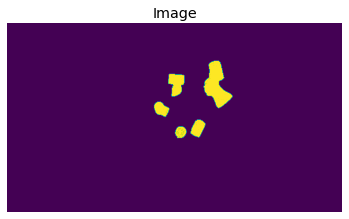

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


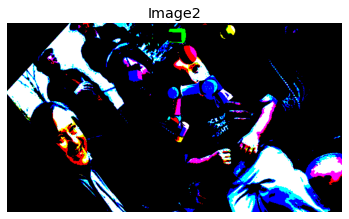

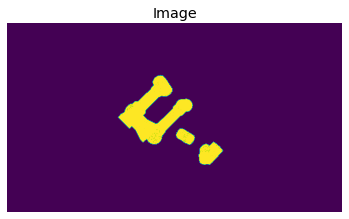

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


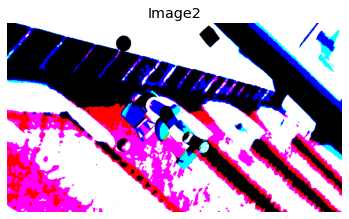

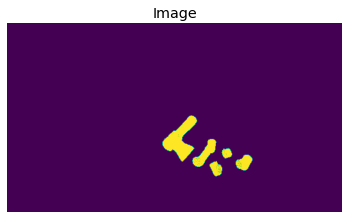

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


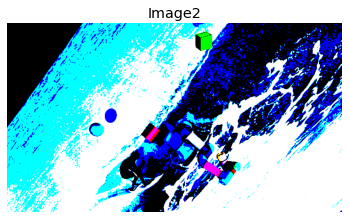

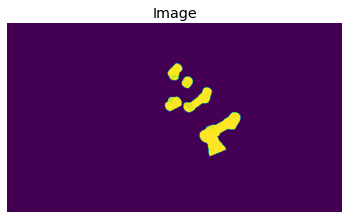

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


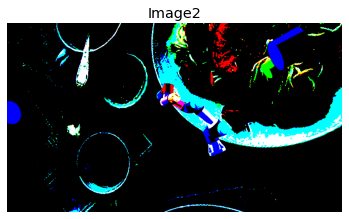

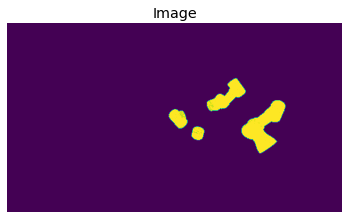

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


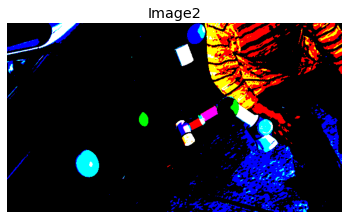

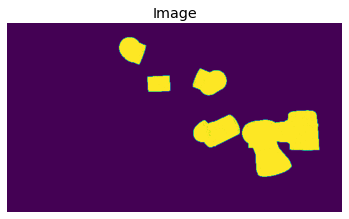

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


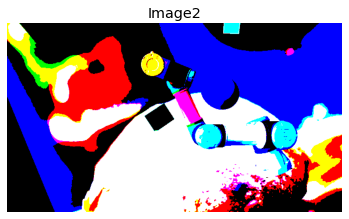

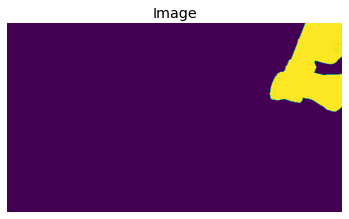

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


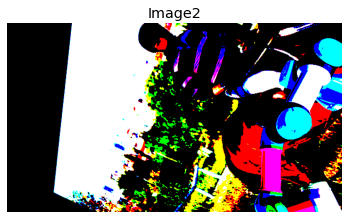

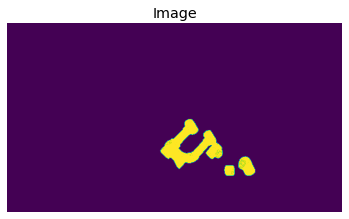

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


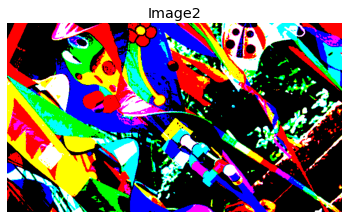

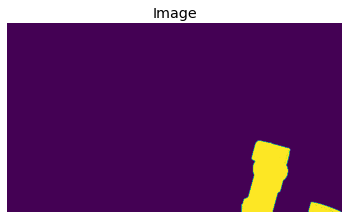

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


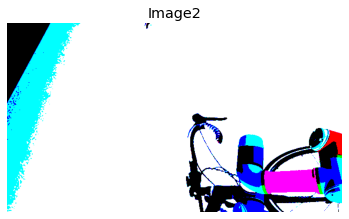

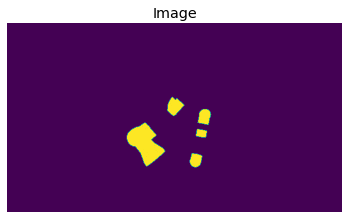

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


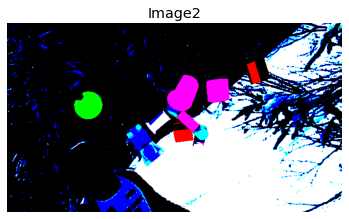

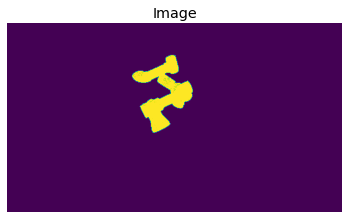

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


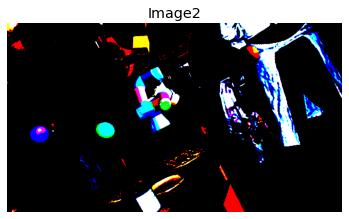

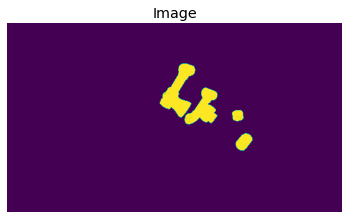

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


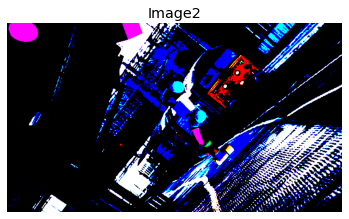

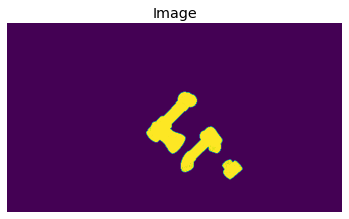

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


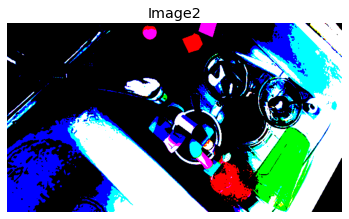

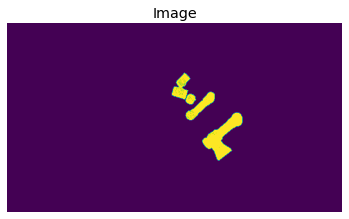

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


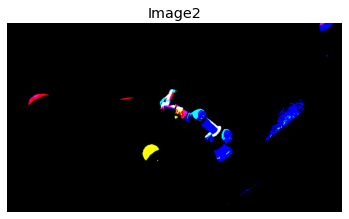

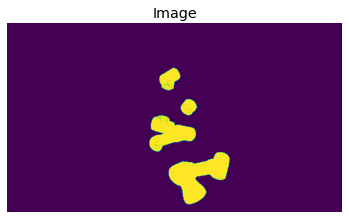

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


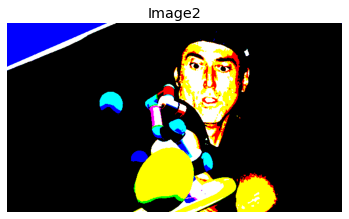

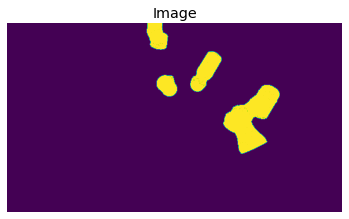

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


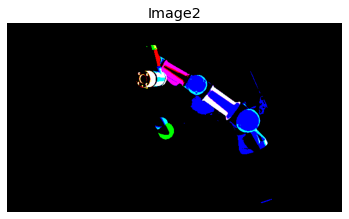

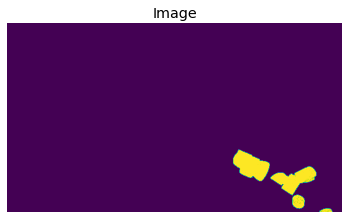

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


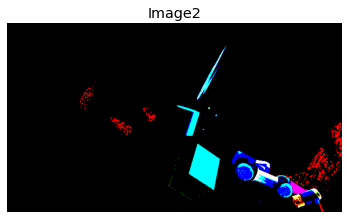

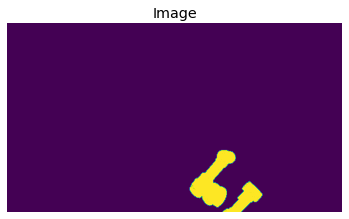

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


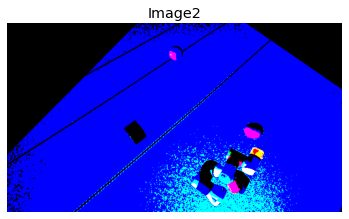

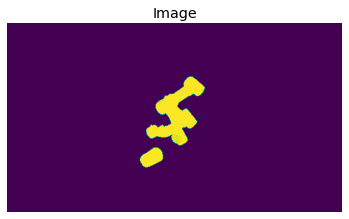

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


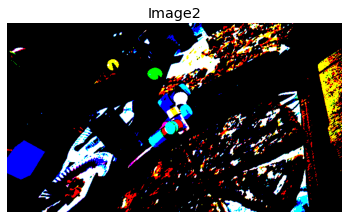

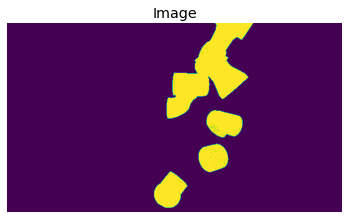

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


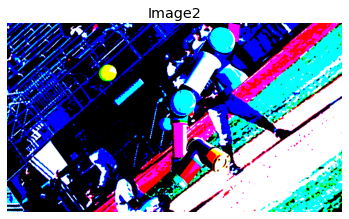

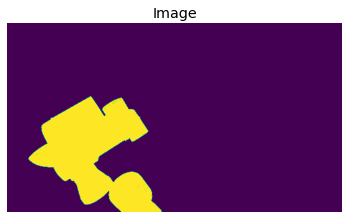

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


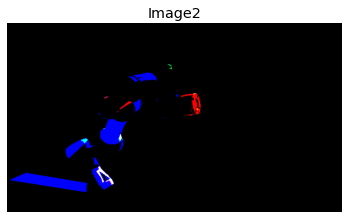

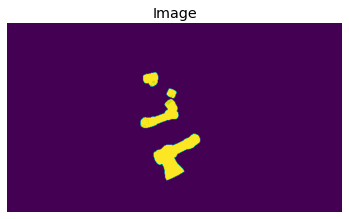

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


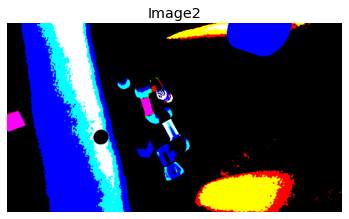

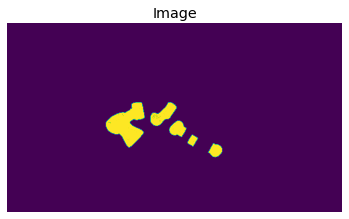

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


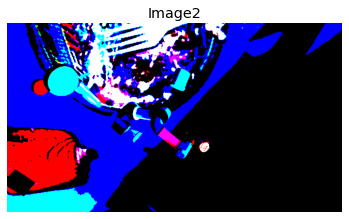

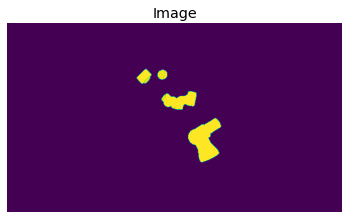

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


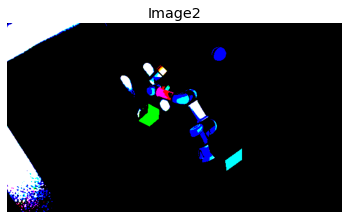

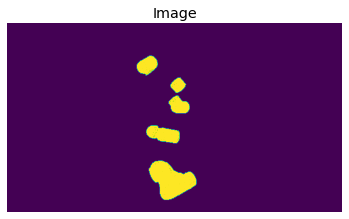

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


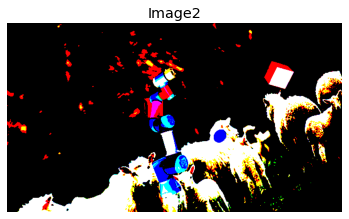

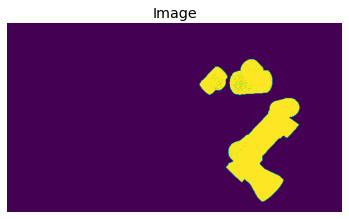

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


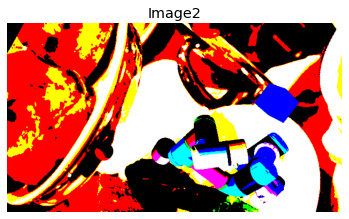

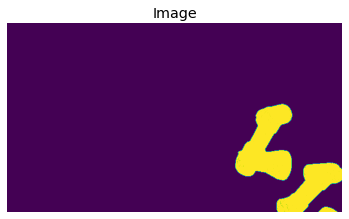

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


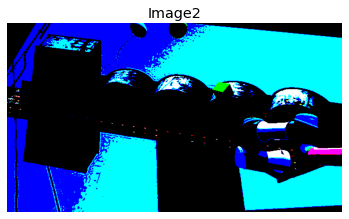

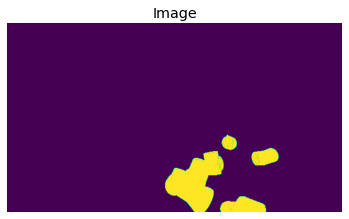

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


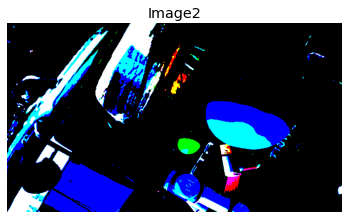

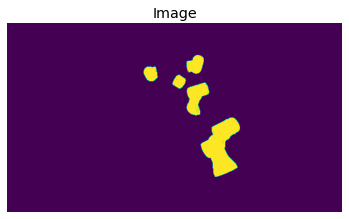

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


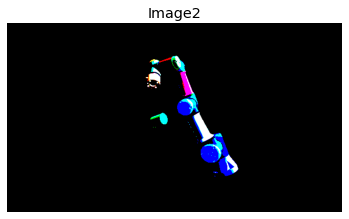

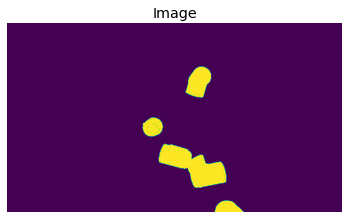

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


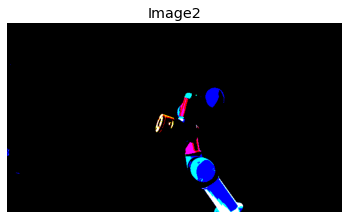

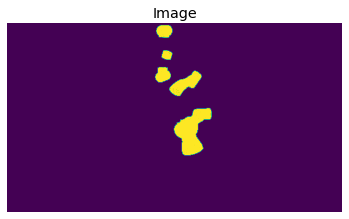

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


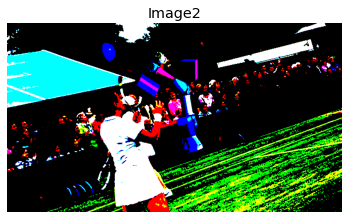

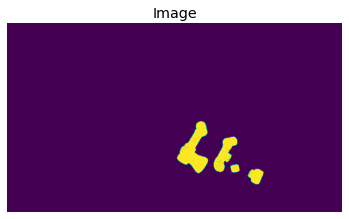

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


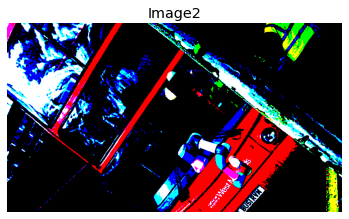

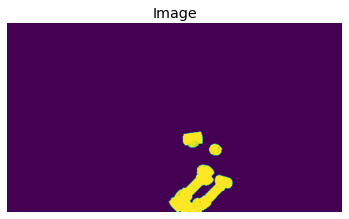

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


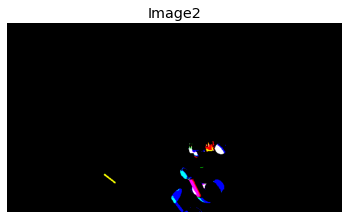

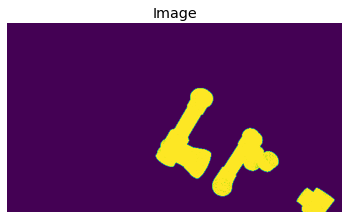

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


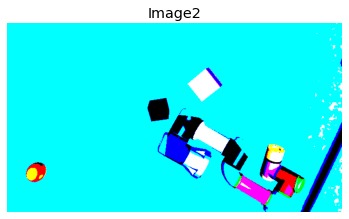

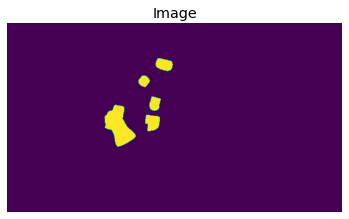

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


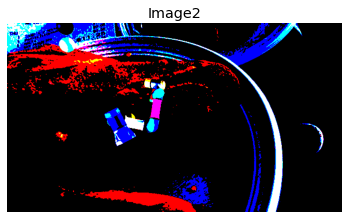

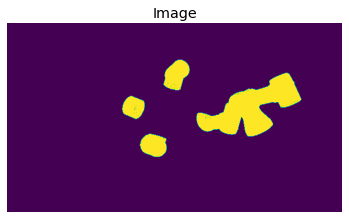

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


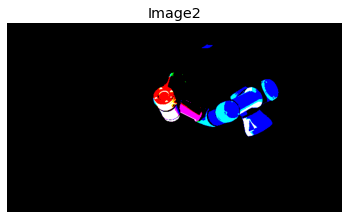

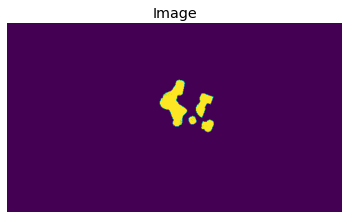

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


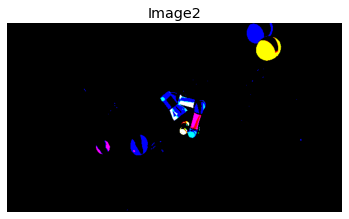

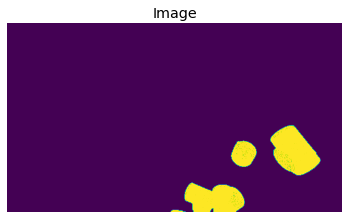

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


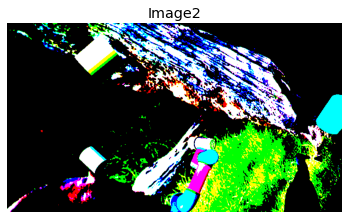

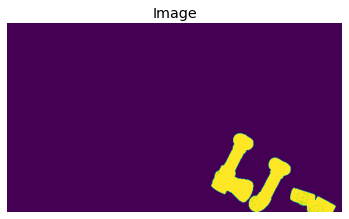

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


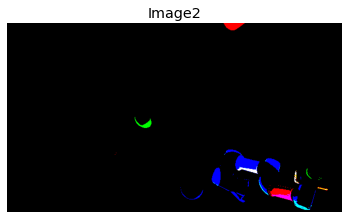

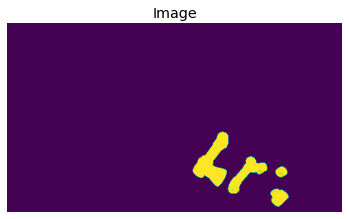

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


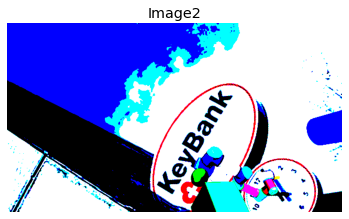

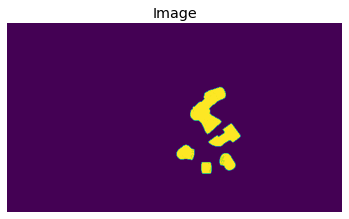

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


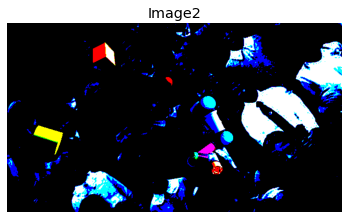

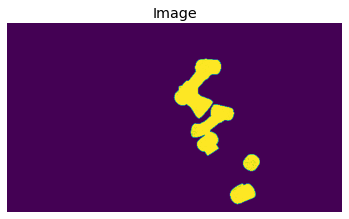

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


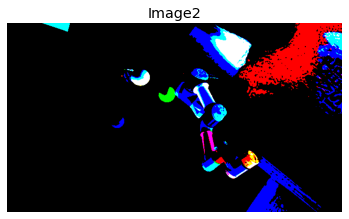

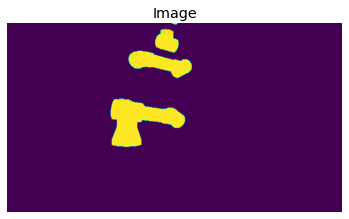

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


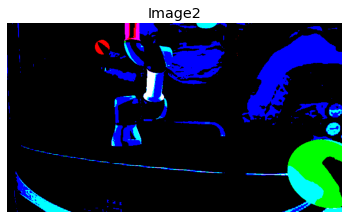

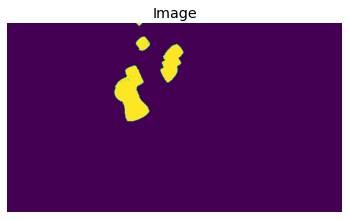

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


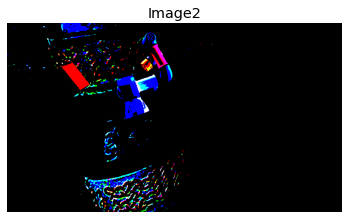

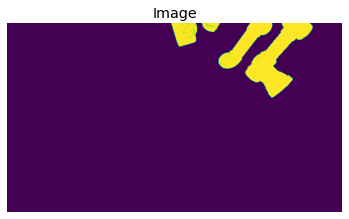

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


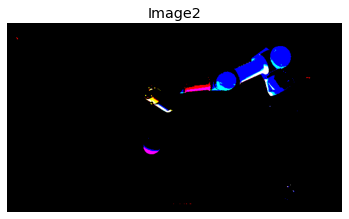

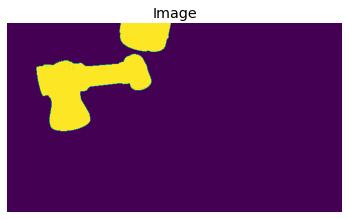

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


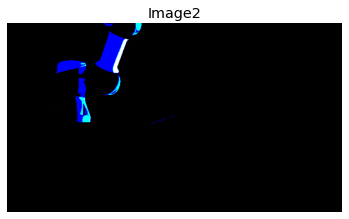

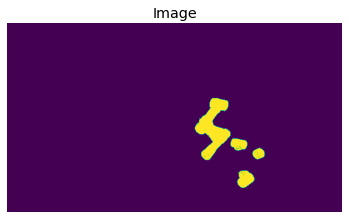

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


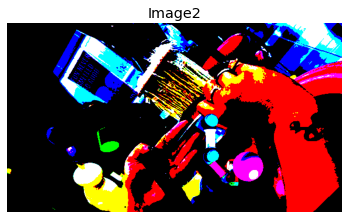

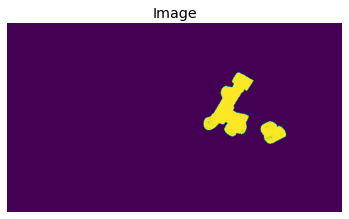

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


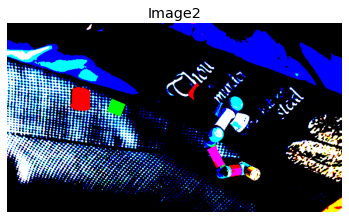

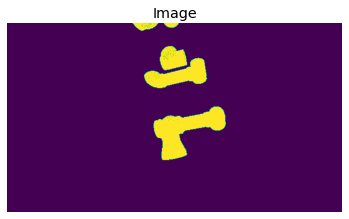

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


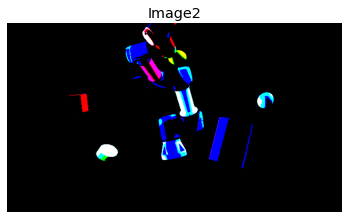

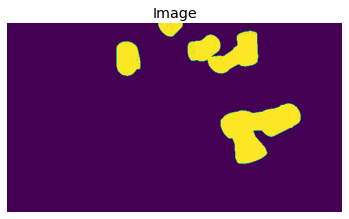

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


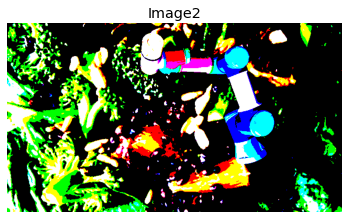

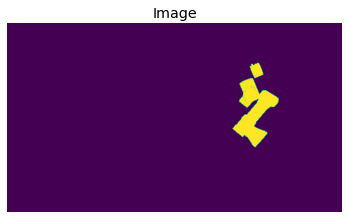

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


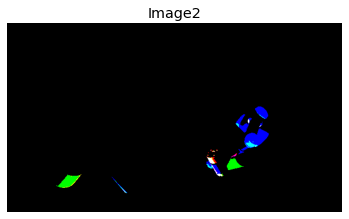

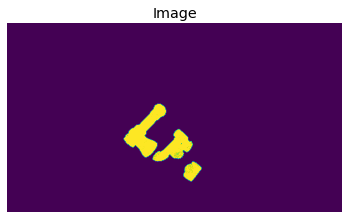

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


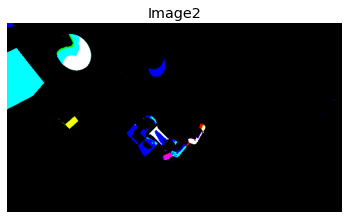

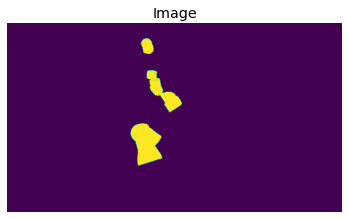

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


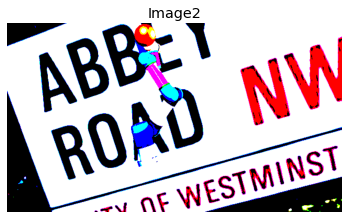

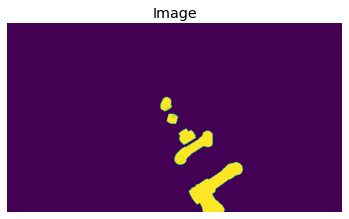

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


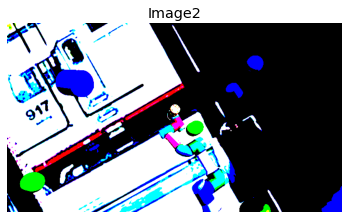

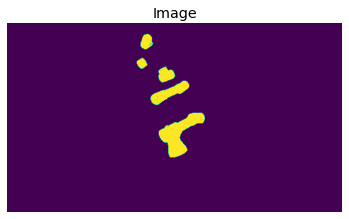

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


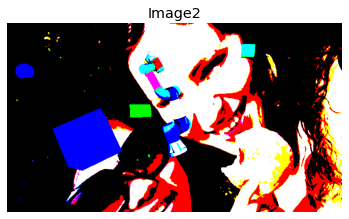

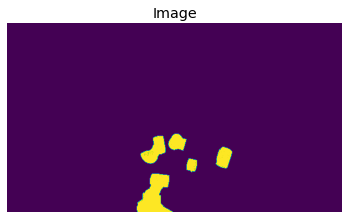

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


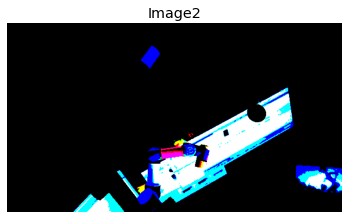

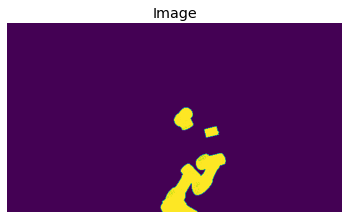

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


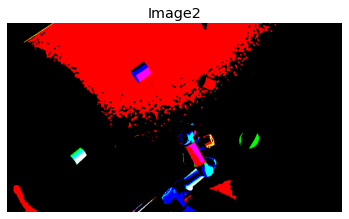

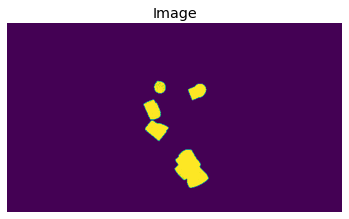

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


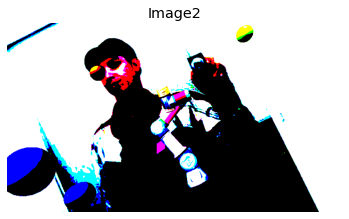

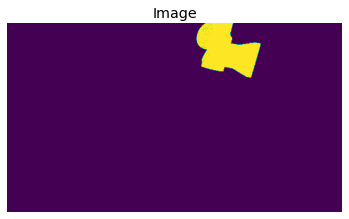

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


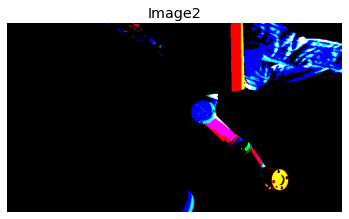

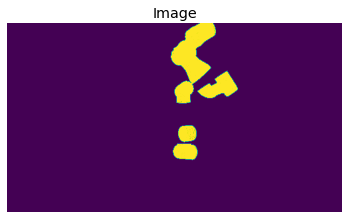

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


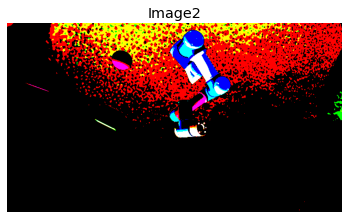

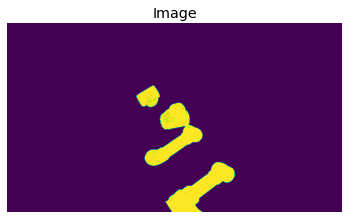

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


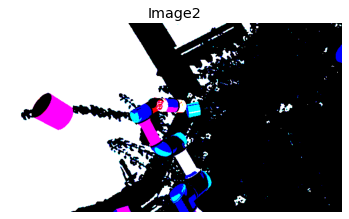

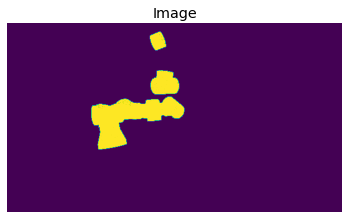

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


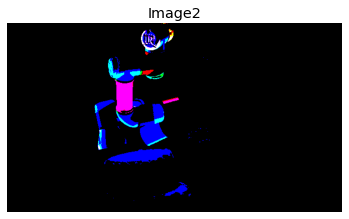

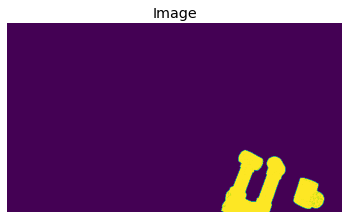

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


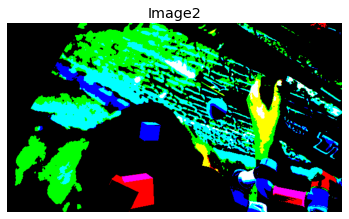

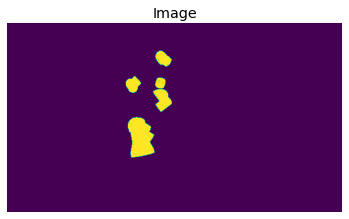

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


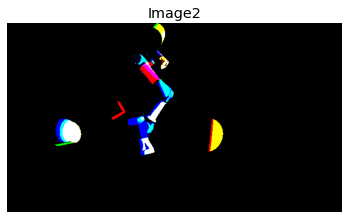

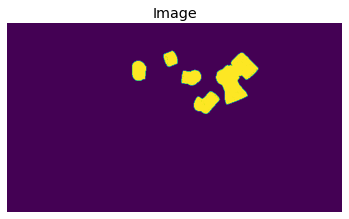

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


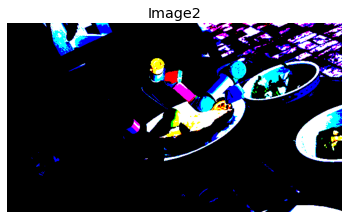

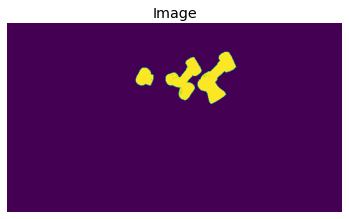

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


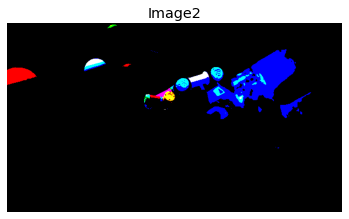

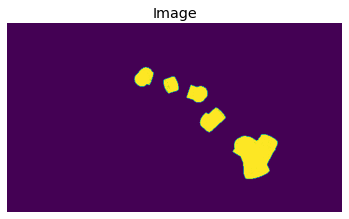

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


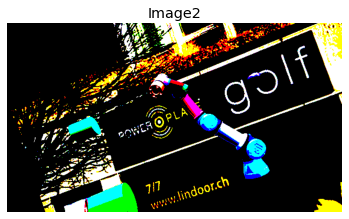

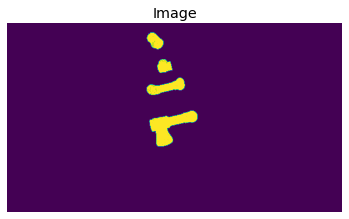

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


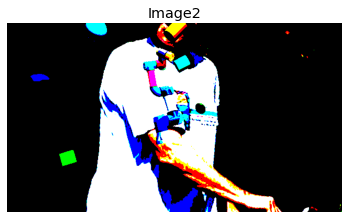

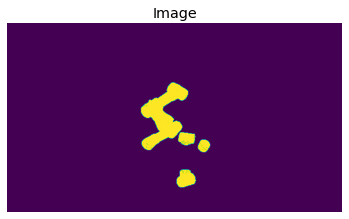

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


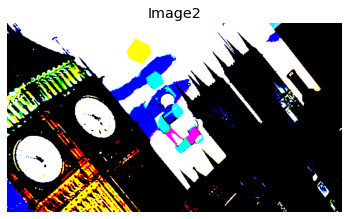

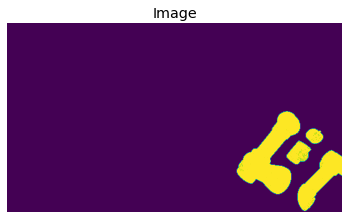

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


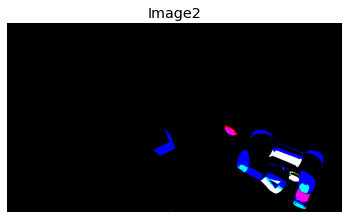

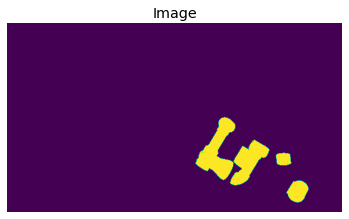

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


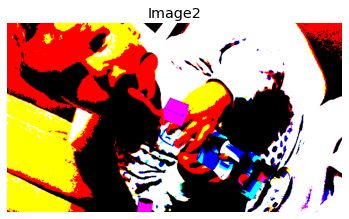

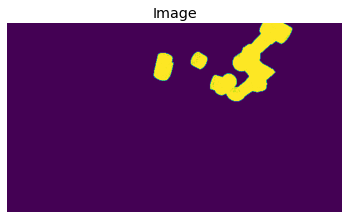

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


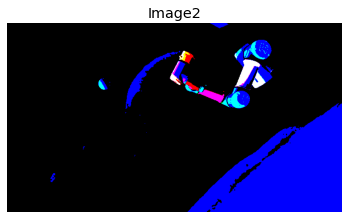

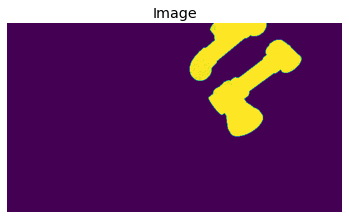

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


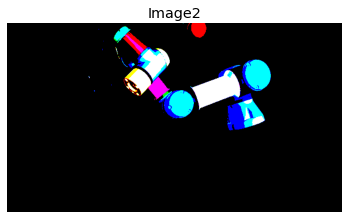

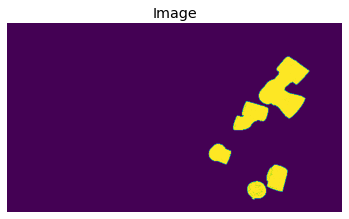

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


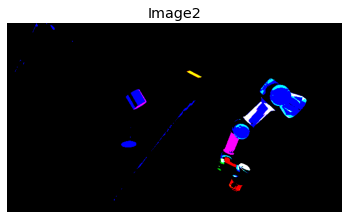

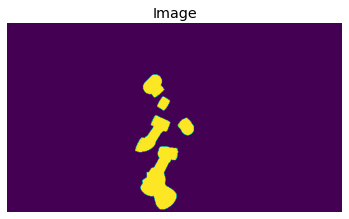

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


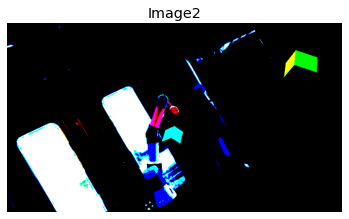

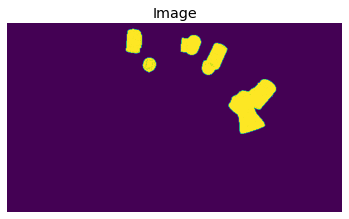

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


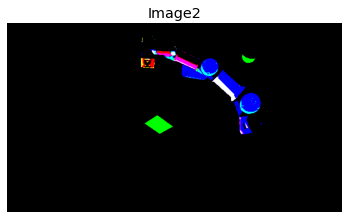

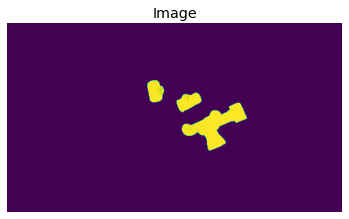

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


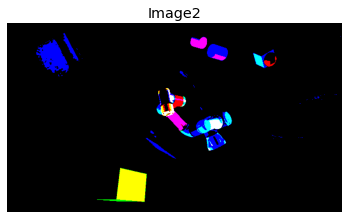

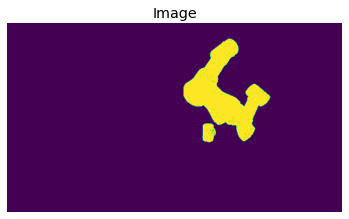

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


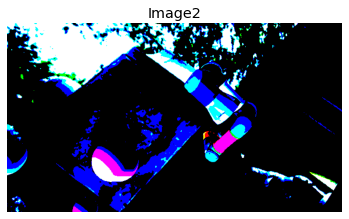

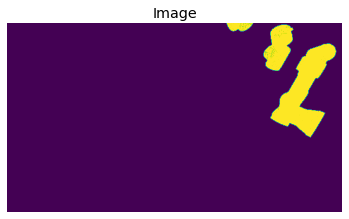

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: 

In [8]:
#point_idx_list = [0,2,3,4,6,7,8]
point_idx_list = [0,2,3,4,5,6,7]

st_epoch = 0
epoch_writer = SummaryWriter(comment="_writter")

best_valid_loss = np.inf

for epoch in range(0, args.n_epoch):
    phases = ['train','valid']

    for phase in phases:
        iter_writer = SummaryWriter(comment="_epoch_" + str(epoch) + "_" + phase)

        # train keypoint detector
        
        keypoint_seg_predictor.train(phase == 'train')

        meter_loss = AverageMeter()
        meter_loss_kp = AverageMeter()
        meter_loss_seg = AverageMeter()


        loader = dataloaders[phase]

        #bar = ProgressBar(maxval=data_n_batches[phase])
        for i, data in tqdm(enumerate(loader), total=data_n_batches[phase]):

            if args.use_gpu:
                if isinstance(data, list):
                    data = [d.cuda() for d in data]
                else:
                    data = data.cuda()

            # load data
            img, joint_angle, base_to_cam = data

            # generate ground truth
            mask_list_gt = list()
            points_2d_gt_list = list()
            for b in range(img.shape[0]):
                robot_mesh = panda_renderer.get_robot_mesh(joint_angle[b].cpu().squeeze()) 
                #robot_mesh = panda_renderer.get_robot_mesh(np.array((0,0,0,0,0,0))) 
                rendered_image = panda_renderer.silhouette_renderer(meshes_world=robot_mesh, R = base_to_cam[b,:3,:3].T.unsqueeze(0), T = base_to_cam[b,:3,3].unsqueeze(0))
                plt.imshow(np.squeeze(rendered_image.cpu()[..., 3]))
                plt.title("Image")
                plt.axis('off')
                plt.show()
                plt.imshow(np.transpose(np.squeeze(img.cpu()[b]), (1, 2, 0))*255)
                plt.title("Image2")
                plt.axis('off')
                plt.show()
                

#                 mask_list_gt.append(rendered_image[..., 3])

#                 _,t_list = ur_arm.get_joint_RT(joint_angle[b].cpu().squeeze())
#                 points_3d = torch.from_numpy(t_list).double().to(device)
#                 points_3d = points_3d[point_idx_list]
#                 points_2d_gt = BPnP.batch_project(base_to_cam[b,:3,:4][None], points_3d, K, angle_axis=False)
#                 points_2d_gt_list.append(points_2d_gt)
#                 # debug
#                 #if (points_2d_gt[0,:,0] > args.width).any():
#                 #    print(points_2d_gt[0,(points_2d_gt[0,:,0] > args.width)])
#                 #if (points_2d_gt[0,:,1] > args.height).any():
#                 #    print(points_2d_gt[0,(points_2d_gt[0,:,1] > args.height)])

#             mask_batch = torch.cat(mask_list_gt,0)
#             points_2d_gt_batch = torch.cat(points_2d_gt_list,0)
#             valid_point_table = torch.logical_and(torch.logical_and(points_2d_gt_batch[:,:,0] < args.width, points_2d_gt_batch[:,:,0] > 0), 
#                                       torch.logical_and(points_2d_gt_batch[:,:,1] < args.height, points_2d_gt_batch[:,:,1] > 0))


#             with torch.set_grad_enabled(phase == 'train'):


#                 # detect 2d keypoints
#                 points_2d, segmentation = keypoint_seg_predictor(img)

#                 loss_seg = criterionBCE(segmentation.squeeze(), mask_batch)
#                 loss_kp = criterionMSE_mean(points_2d_gt_batch[valid_point_table], points_2d[valid_point_table])

#                 loss = 0.1 * loss_kp + loss_seg
#                 loss = loss.float()
#                 meter_loss.update(loss.item(), n=img.size(0))
#                 meter_loss_kp.update(loss_kp.item(), n=img.size(0))
#                 meter_loss_seg.update(loss_seg.item(), n=img.size(0))

#             if phase == 'train':
#                 optimizer.zero_grad()
#                 loss.type(torch.float)
#                 torch.nn.utils.clip_grad_value_(keypoint_seg_predictor.parameters(), 10)
#                 optimizer.step()

#             # write to log

#             iter_writer.add_scalar('loss_kp', loss_kp.item(), i)

#             if (i%200==0 and phase=='train') or (phase=='valid' and i%20==0):

#                 img_np = to_numpy_img(img[0])
#                 img_np_pred = overwrite_image(img_np.copy(),points_2d[0].detach().cpu().numpy().squeeze().astype(int), color=(0,1,0),point_size=6)
#                 img_np_gt = overwrite_image(img_np.copy(),points_2d_gt_batch[0].detach().cpu().numpy().squeeze().astype(int), color=(0,1,0),point_size=6)
#                 iter_writer.add_image('[keypoint] gt vs predict', np.concatenate((img_np_gt,img_np_pred),axis=1), i, dataformats='HWC')

#                 iter_writer.add_image('[segmentation] gt vs predict', np.concatenate((mask_batch[0].squeeze().cpu().detach().numpy(),
#                                                                         torch.sigmoid(segmentation[0]).squeeze().cpu().detach().numpy()),
#                                                                         axis=1), i, dataformats='HW')

#         log = '%s [%d/%d] Loss: %.6f, LR: %f' % (
#             phase, epoch, args.n_epoch,
#             meter_loss.avg,
#             get_lr(optimizer))

#         iter_writer.close()

#         print(log)

#         if phase == 'valid':
#             epoch_writer.add_scalar('loss_kp_val', meter_loss_kp.avg, epoch)
#             epoch_writer.add_scalar('loss_seg_val', meter_loss_seg.avg, epoch)
#             epoch_writer.add_scalar('loss_all_val', meter_loss.avg, epoch)

#             scheduler.step(meter_loss.avg)
#             if meter_loss.avg < best_valid_loss:
#                 best_valid_loss = meter_loss.avg

#                 torch.save(keypoint_seg_predictor.state_dict(), '%s/net_best.pth' % (args.out_dir))

#             log = 'Best valid: %.6f' % (best_valid_loss)
#             print(log)
#             torch.save(keypoint_seg_predictor.state_dict(), '%s/net_last.pth' % (args.out_dir))
#         else:
#             epoch_writer.add_scalar('loss_kp', meter_loss_kp.avg, epoch)
#             epoch_writer.add_scalar('loss_seg', meter_loss_seg.avg, epoch)
#             epoch_writer.add_scalar('loss_all', meter_loss.avg, epoch)
            
# epoch_writer.close()




[[ 0.          0.          0.          0.          0.          0.
   1.8       ]
 [ 0.          0.          0.          0.          0.          0.
   1.8       ]
 [ 0.          0.          0.          0.          0.          0.
   1.8       ]
 [ 0.          0.          0.          0.          0.          0.
   1.8       ]
 [ 0.          0.          0.          0.          0.          0.
   1.8       ]
 [ 0.          0.          0.          0.5         0.          0.
   1.        ]
 [ 0.          0.          0.          0.5         0.          0.
   1.        ]
 [ 0.          0.          0.          0.5         0.          0.
   1.        ]
 [ 0.          0.          0.          0.5         0.          0.
   1.        ]
 [ 0.          0.          0.          0.5         0.          0.
   1.        ]
 [ 0.         -0.5         0.          0.5         0.          0.
   1.5       ]
 [ 0.         -0.5         0.          0.5         0.          0.
   1.5       ]
 [ 0.         -0.5         0